In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd 

from transformers import BertModel, BertTokenizer
from IPython import embed

from itertools import cycle
from pprint import pprint as pp
from tqdm import tqdm
from copy import deepcopy as dc

In [6]:
class FineTuningDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        super(FineTuningDataset, self).__init__()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.df = dc(dataframe)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        text = self.df["text"][idx]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        targets = self.df["one_hot"][idx].to_numpy()

        return {
            "ids" : torch.tensor(ids, dtype=torch.long),
            "mask" : torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long)
        }
class BERTClass(torch.nn.Module):
    def __init__(self, n_labels):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = nn.Dropout(0.3) # Try this .1
        # this is the layer that return the labels => must have the same number of labels the training set is emitting
        self.l3 = nn.Linear(768, n_labels)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output
class StreamingDataset(IterableDataset):
    def __init__(self, file, tokenizer, max_len):
        super(StreamingDataset).__init__()
        self.file = file
        self.tokenizer = tokenizer
        self.max_len = max_len

    def parse_file(self, filename):
        with open(filename) as file:
            for line in file:

                inputs = self.tokenizer.encode_plus(
                    line,
                    None,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    pad_to_max_length=True,
                    return_token_type_ids=True,
                    padding="max_length",
                    truncation=True
                )
    
                ids = inputs["input_ids"]
                mask = inputs["attention_mask"]
                token_type_ids = inputs["token_type_ids"]
                text = line
                
                yield {
                    "ids": torch.tensor(ids),
                    "mask": torch.tensor(mask),
                    "token_type_ids": torch.tensor(token_type_ids),
                    "text": text
                }

    def get_stream(self, filename):
        return cycle(self.parse_file(filename))

    def __iter__(self):
        return self.get_stream(self.file)

In [7]:
MODEL_DIR = "../../data/models/bert_15ep_5e5_280ml"
MODEL_NAME = "../../data/models/bert_15ep_5e5_280ml/pytorch_model.bin"
EVAL_DS_FILENAME = "../../data/raw/flaws_cloudtrail02.ndjson"
MAX_LEN = 200
N_LABELS = 114
THRESHOLD = 0.3
BATCH_SIZE = 4

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading tokenizer...")
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR) 

print("Loading Model...")

model = BERTClass(n_labels=N_LABELS)

model.load_state_dict(
    torch.load(
            MODEL_NAME, 
            map_location=device,
            weights_only=True
    )
)

print("Initilaizing evaluation...")

iter_ds = StreamingDataset(EVAL_DS_FILENAME, tokenizer, MAX_LEN)
iter_dl = DataLoader(iter_ds, batch_size=BATCH_SIZE)

# targets = self.df["one_hot"][idx].to_numpy()

def transform_from_softmax(input):
    out = F.sigmoid(input)
    return out


Using device: cpu
Loading tokenizer...
Loading Model...
Initilaizing evaluation...


In [9]:
with torch.no_grad():
    for batch in tqdm(iter_dl): # iterate over DataLoader
        ids = batch["ids"].to(device, dtype=torch.long)
        mask = batch["mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        output = model(ids, mask, token_type_ids)

        break

0it [00:02, ?it/s]


In [10]:
output

tensor([[ 1.9282, -6.4672, -6.8680, -8.6232, -6.0613, -4.4792, -6.2379, -6.5528,
         -7.4586, -7.1469, -6.9628, -6.2170, -4.9390, -6.0181, -7.2706, -6.7134,
         -6.1984, -6.3456, -8.4366, -6.4417, -7.2818, -7.2723, -7.3046, -7.1632,
         -8.4377, -5.5037, -5.9017, -6.1056, -6.7001, -5.8099, -6.6751, -8.2323,
         -5.7439, -6.8281, -6.8746, -7.2859, -5.7380, -6.2869, -6.9949, -6.8549,
         -7.1486, -6.8452, -5.8921, -6.6256, -5.9749, -7.5000, -6.6819, -6.7590,
         -5.6862, -6.9145, -7.8878, -7.7071, -6.7984, -5.5207, -6.5717, -7.0547,
         -6.8779, -8.0944, -6.8295, -6.1880, -5.4165, -6.4724, -6.3870, -7.8384,
         -6.3269, -6.9483, -6.4734, -7.4346, -6.9915, -7.6854, -7.4568, -7.8278,
         -7.1908, -7.5288, -7.5647, -8.2323, -7.7529, -7.0195, -8.0960, -6.7863,
         -7.0815, -7.3570, -7.3140, -7.3581, -6.6041, -6.0175, -7.0642, -4.6459,
         -7.4738, -6.2956, -7.0686, -5.9869, -5.7371, -6.5829, -7.4137, -7.1414,
         -5.8686, -6.7514, -

In [24]:
f_sigmoid = F.sigmoid(output).numpy()
f_softmax = F.softmax(output, dim=1).numpy()

In [20]:
import seaborn as sns
import polars as pl

In [25]:
df_sigmoid = pl.DataFrame(f_sigmoid[0]).with_row_index()
df_softmax = pl.DataFrame(f_softmax[0]).with_row_index()

In [28]:
df_sigmoid

index,column_0
u32,f32
0,0.873055
1,0.001551
2,0.001039
3,0.00018
4,0.002326
…,…
109,0.004479
110,0.000759
111,0.003636


<Axes: >

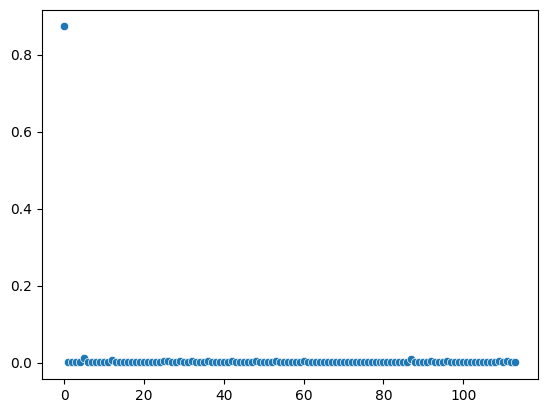

In [29]:
sns.scatterplot(df_sigmoid['column_0'])

<Axes: >

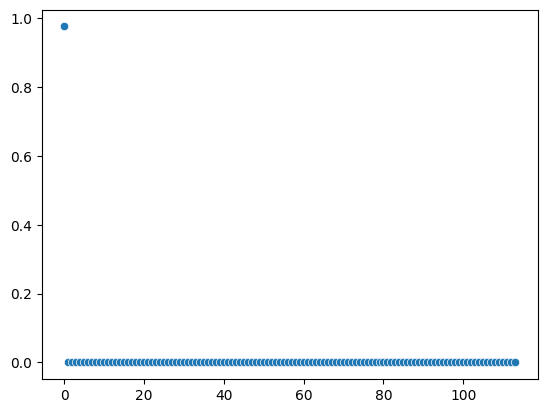

In [30]:
sns.scatterplot(df_softmax['column_0'])

In [34]:
df_softmax['column_0'].to_numpy().max().item(), df_softmax['column_0'].to_numpy().argmax().item()

(0.9753716588020325, 0)

In [42]:
for i in f_softmax:
    print((i.argmax(), i.max()))

(np.int64(0), np.float32(0.97537166))
(np.int64(0), np.float32(0.3723974))
(np.int64(0), np.float32(0.8228963))
(np.int64(0), np.float32(0.9222709))


In [51]:
for i in f_sigmoid:
    #filtered = np.where(i >= 0.5)
    print( (i.argmax(), i.max()) )

(np.int64(0), np.float32(0.8730552))
(np.int64(0), np.float32(0.12370581))
(np.int64(0), np.float32(0.40618825))
(np.int64(0), np.float32(0.65168846))


In [55]:
F.sigmoid(output[0]).numpy().max()

np.float32(0.8730552)